<a href="https://colab.research.google.com/github/RobertGrados/QuantumGravity/blob/master/MAqMLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


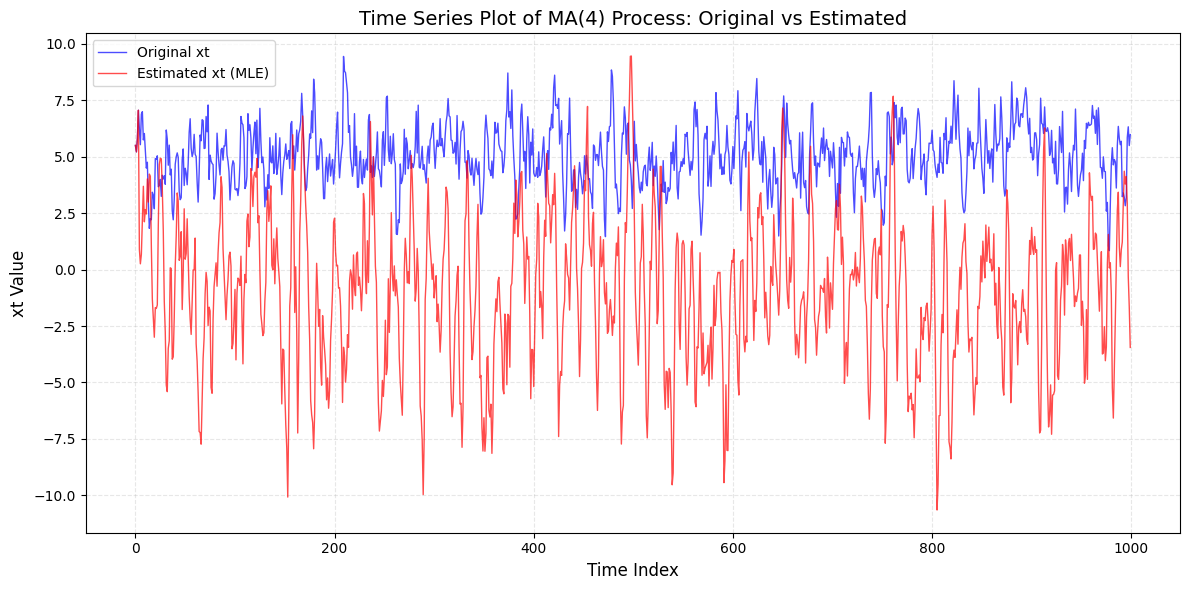

MLE Results:
                                MAqMLE Results                                
Dep. Variable:                     xt   Log-Likelihood:                -2128.9
Model:                         MAqMLE   AIC:                             4270.
Method:            Maximum Likelihood   BIC:                             4299.
Date:                Fri, 05 Jul 2024                                         
Time:                        06:37:55                                         
No. Observations:                1000                                         
Df Residuals:                     994                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5680        nan        nan        nan         nan         nan
beta1          1.2123        nan       

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm

def generate_maq_data(q, alpha, betas, std, N):
    """Generate data for MA(q) process"""
    np.random.seed(42)  # for reproducibility
    et = np.random.normal(loc=0, scale=std, size=N)
    xt = [alpha + et[0]]
    for t in range(1, N):
        xt_t = alpha + et[t]
        for j in range(min(t, q)):
            xt_t += betas[j] * et[t-j-1]
        xt.append(xt_t)
    return np.array(xt), et

class MAqMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, q, **kwds):
        self.q = q  # Initialize q here
        super(MAqMLE, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        return -self.loglikeobs(params)

    def loglikeobs(self, params):
        ets = self.calc_conditional_et(params)
        return stats.norm.logpdf(ets, scale=params[-1])

    def initialize(self):
        super().initialize()
        extra_params_names = [f'beta{i+1}' for i in range(self.q)] + ['std']
        self._set_extra_params_names(extra_params_names)
        self.start_params = np.array([0.1] * (self.q + 2))  # alpha, betas, std

    def calc_conditional_et(self, params):
        intercept = params[0]
        betas = params[1:-1]
        df = pd.DataFrame({"xt": self.endog})
        ets = [0.0] * self.q  # Initialize first q error terms as 0
        for t in range(self.q, len(df)):
            et = df.iloc[t]["xt"] - intercept
            for j in range(self.q):
                et -= betas[j] * ets[t-j-1]
            ets.append(et)
        return ets[self.q:]  # Return only the calculated errors

# Set parameters
q = 4  # Order of MA process
N = 1000  # Number of data points
MEAN = 0
STD = 1
ALPHA = 5
BETAS = [0.7, 0.5, 0.3, 0.2]  # Beta coefficients for MA(q)

# Generate data
xt, et = generate_maq_data(q, ALPHA, BETAS, STD, N)
df = pd.DataFrame({"xt": xt})

# Fit the model
df = sm.add_constant(df)  # add intercept for estimation (alpha)
model = MAqMLE(df["xt"], df["const"], q=q)
results = model.fit()

# Generate estimated series
estimated_params = results.params
estimated_alpha = estimated_params[0]
estimated_betas = estimated_params[1:-1]
estimated_std = estimated_params[-1]

estimated_et = np.random.normal(loc=MEAN, scale=estimated_std, size=N)
estimated_xt = list(df["xt"].iloc[:q])  # Start with the first q observed values

for t in range(q, N):
    xt_t = estimated_alpha + estimated_et[t]
    for j in range(q):
        xt_t += estimated_betas[j] * estimated_et[t-j-1]
    estimated_xt.append(xt_t)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['xt'], color='blue', linewidth=1, alpha=0.7, label='Original xt')
plt.plot(df.index, estimated_xt, color='red', linewidth=1, alpha=0.7, label='Estimated xt (MLE)')

plt.xlabel('Time Index', fontsize=12)
plt.ylabel('xt Value', fontsize=12)
plt.title(f'Time Series Plot of MA({q}) Process: Original vs Estimated', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

# Print results
print("MLE Results:")
print(results.summary())
print("\nTrue values:")
print(f"ALPHA: {ALPHA}")
for i, beta in enumerate(BETAS, 1):
    print(f"BETA{i}: {beta}")
print(f"STD: {STD}")
print("\nEstimated values:")
print(f"Estimated ALPHA: {estimated_alpha}")
for i, beta in enumerate(estimated_betas, 1):
    print(f"Estimated BETA{i}: {beta}")
print(f"Estimated STD: {estimated_std}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm
from scipy.optimize import minimize

def generate_maq_data(q, alpha, betas, std, N):
    """Generate data for MA(q) process"""
    np.random.seed(42)  # for reproducibility
    et = np.random.normal(loc=0, scale=std, size=N)
    xt = [alpha + et[0]]
    for t in range(1, N):
        xt_t = alpha + et[t]
        for j in range(min(t, q)):
            xt_t += betas[j] * et[t-j-1]
        xt.append(xt_t)
    return np.array(xt), et

class MAqMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, q, **kwds):
        self.q = q
        super(MAqMLE, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        return -self.loglikeobs(params).sum()

    def loglikeobs(self, params):
        alpha, betas, sigma = params[0], params[1:-1], params[-1]
        ets = self.calc_conditional_et(alpha, betas, sigma)
        return stats.norm.logpdf(ets, scale=sigma)

    def initialize(self):
        super().initialize()
        extra_params_names = [f'beta{i+1}' for i in range(self.q)] + ['sigma']
        self._set_extra_params_names(extra_params_names)
        self.start_params = np.concatenate(([np.mean(self.endog)],  # alpha
                                            [0.1] * self.q,  # betas
                                            [np.std(self.endog)]))  # sigma

    def calc_conditional_et(self, alpha, betas, sigma):
        xt = self.endog
        et = np.zeros_like(xt)
        for t in range(len(xt)):
            et[t] = xt[t] - alpha
            for j in range(min(t, self.q)):
                et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
        return et

    def fit(self, start_params=None, maxiter=10000, method='L-BFGS-B', **kwds):
        if start_params is None:
            start_params = self.start_params

        bounds = [(None, None)]  # alpha
        bounds.extend([(-0.99, 0.99) for _ in range(self.q)])  # betas
        bounds.append((1e-6, None))  # sigma

        results = minimize(self.nloglikeobs, start_params,
                           method=method, bounds=bounds,
                           options={'maxiter': maxiter})

        return self.fit_results(results)

# Set parameters
q = 4  # Order of MA process
N = 10000  # Increased number of data points
MEAN = 0
STD = 1
ALPHA = 5
BETAS = [0.7, 0.5, 0.3, 0.2]  # Beta coefficients for MA(q)

# Generate data
xt, et = generate_maq_data(q, ALPHA, BETAS, STD, N)
df = pd.DataFrame({"xt": xt})

# Fit the model
df = sm.add_constant(df)  # add intercept for estimation (alpha)
model = MAqMLE(df["xt"], df["const"], q=q)
results = model.fit()

# Generate estimated series
estimated_params = results.params
estimated_alpha = estimated_params[0]
estimated_betas = estimated_params[1:-1]
estimated_std = estimated_params[-1]

estimated_et = np.random.normal(loc=MEAN, scale=estimated_std, size=N)
estimated_xt = list(df["xt"].iloc[:q])  # Start with the first q observed values

for t in range(q, N):
    xt_t = estimated_alpha + estimated_et[t]
    for j in range(q):
        xt_t += estimated_betas[j] * estimated_et[t-j-1]
    estimated_xt.append(xt_t)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[:1000], df['xt'][:1000], color='blue', linewidth=1, alpha=0.7, label='Original xt')
plt.plot(df.index[:1000], estimated_xt[:1000], color='red', linewidth=1, alpha=0.7, label='Estimated xt (MLE)')

plt.xlabel('Time Index', fontsize=12)
plt.ylabel('xt Value', fontsize=12)
plt.title(f'Time Series Plot of MA({q}) Process: Original vs Estimated', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

# Print results
print("MLE Results:")
print(results.summary())
print("\nTrue values:")
print(f"ALPHA: {ALPHA}")
for i, beta in enumerate(BETAS, 1):
    print(f"BETA{i}: {beta}")
print(f"STD: {STD}")
print("\nEstimated values:")
print(f"Estimated ALPHA: {estimated_alpha}")
for i, beta in enumerate(estimated_betas, 1):
    print(f"Estimated BETA{i}: {beta}")
print(f"Estimated STD: {estimated_std}")

AttributeError: 'MAqMLE' object has no attribute 'fit_results'

<ipython-input-4-85163496c86b>:79: RuntimeWarning: invalid value encountered in sqrt
  res.bse = np.sqrt(np.diag(res.cov_params))


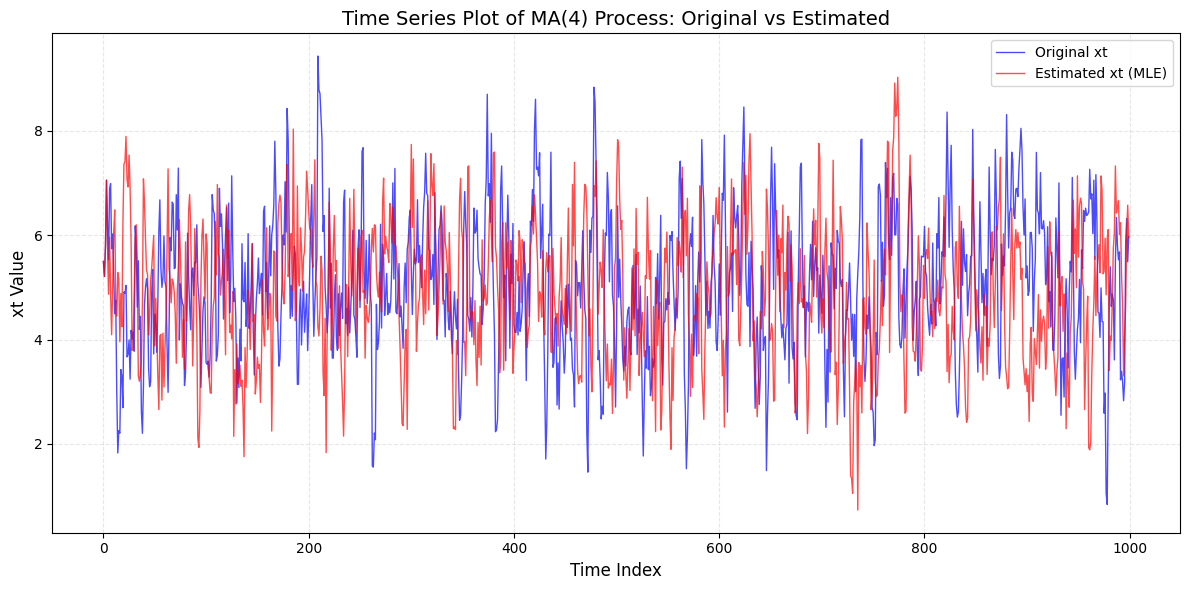

MLE Results:
MAqMLE Results Summary:
-----------------------
Parameter  Estimate     Std. Error  
alpha          4.994385          nan
beta1          0.686425     0.000971
beta2          0.478141     0.002343
beta3          0.285257          nan
beta4          0.188485     0.000481
sigma          1.003229     0.004544

Log-likelihood: -14221.488023

True values:
ALPHA: 5
BETA1: 0.7
BETA2: 0.5
BETA3: 0.3
BETA4: 0.2
STD: 1

Estimated values:
Estimated ALPHA: 4.994385021249747
Estimated BETA1: 0.6864251262407304
Estimated BETA2: 0.47814125737853497
Estimated BETA3: 0.2852569140498441
Estimated BETA4: 0.18848495301640736
Estimated STD: 1.0032291525096249


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_fprime

def generate_maq_data(q, alpha, betas, std, N):
    """Generate data for MA(q) process"""
    np.random.seed(42)  # for reproducibility
    et = np.random.normal(loc=0, scale=std, size=N)
    xt = [alpha + et[0]]
    for t in range(1, N):
        xt_t = alpha + et[t]
        for j in range(min(t, q)):
            xt_t += betas[j] * et[t-j-1]
        xt.append(xt_t)
    return np.array(xt), et

class MAqMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, q, **kwds):
        self.q = q
        super(MAqMLE, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        return -self.loglikeobs(params).sum()

    def loglikeobs(self, params):
        alpha, betas, sigma = params[0], params[1:-1], params[-1]
        ets = self.calc_conditional_et(alpha, betas, sigma)
        return stats.norm.logpdf(ets, scale=sigma)

    def initialize(self):
        super().initialize()
        extra_params_names = [f'beta{i+1}' for i in range(self.q)] + ['sigma']
        self._set_extra_params_names(extra_params_names)
        self.start_params = np.concatenate(([np.mean(self.endog)],  # alpha
                                            [0.1] * self.q,  # betas
                                            [np.std(self.endog)]))  # sigma

    def calc_conditional_et(self, alpha, betas, sigma):
        xt = self.endog
        et = np.zeros_like(xt)
        for t in range(len(xt)):
            et[t] = xt[t] - alpha
            for j in range(min(t, self.q)):
                et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
        return et

    def fit(self, start_params=None, maxiter=10000, method='L-BFGS-B', **kwds):
        if start_params is None:
            start_params = self.start_params

        bounds = [(None, None)]  # alpha
        bounds.extend([(-0.99, 0.99) for _ in range(self.q)])  # betas
        bounds.append((1e-6, None))  # sigma

        results = minimize(self.nloglikeobs, start_params,
                           method=method, bounds=bounds,
                           options={'maxiter': maxiter})

        return self.process_results(results)

    def process_results(self, results):
        # Create a custom results object
        class ModelResults:
            pass

        res = ModelResults()
        res.params = results.x
        res.success = results.success
        res.nloglike = results.fun

        # Calculate standard errors
        hessian = approx_fprime(results.x, lambda x: approx_fprime(x, self.nloglikeobs))
        res.cov_params = np.linalg.inv(hessian)
        res.bse = np.sqrt(np.diag(res.cov_params))

        # Add method to display results summary
        def summary(self):
            param_names = ['alpha'] + [f'beta{i}' for i in range(1, self.q+1)] + ['sigma']
            summary_str = "MAqMLE Results Summary:\n"
            summary_str += "-----------------------\n"
            summary_str += f"{'Parameter':<10} {'Estimate':<12} {'Std. Error':<12}\n"
            for name, param, se in zip(param_names, self.params, self.bse):
                summary_str += f"{name:<10} {param:12.6f} {se:12.6f}\n"
            summary_str += f"\nLog-likelihood: {-self.nloglike:.6f}"
            return summary_str

        res.summary = summary.__get__(res)
        res.q = self.q

        return res

# Set parameters
q = 4  # Order of MA process
N = 10000  # Increased number of data points
MEAN = 0
STD = 1
ALPHA = 5
BETAS = [0.7, 0.5, 0.3, 0.2]  # Beta coefficients for MA(q)

# Generate data
xt, et = generate_maq_data(q, ALPHA, BETAS, STD, N)
df = pd.DataFrame({"xt": xt})

# Fit the model
df = sm.add_constant(df)  # add intercept for estimation (alpha)
model = MAqMLE(df["xt"], df["const"], q=q)
results = model.fit()

# Generate estimated series
estimated_params = results.params
estimated_alpha = estimated_params[0]
estimated_betas = estimated_params[1:-1]
estimated_std = estimated_params[-1]

estimated_et = np.random.normal(loc=MEAN, scale=estimated_std, size=N)
estimated_xt = list(df["xt"].iloc[:q])  # Start with the first q observed values

for t in range(q, N):
    xt_t = estimated_alpha + estimated_et[t]
    for j in range(q):
        xt_t += estimated_betas[j] * estimated_et[t-j-1]
    estimated_xt.append(xt_t)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[:1000], df['xt'][:1000], color='blue', linewidth=1, alpha=0.7, label='Original xt')
plt.plot(df.index[:1000], estimated_xt[:1000], color='red', linewidth=1, alpha=0.7, label='Estimated xt (MLE)')

plt.xlabel('Time Index', fontsize=12)
plt.ylabel('xt Value', fontsize=12)
plt.title(f'Time Series Plot of MA({q}) Process: Original vs Estimated', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

# Print results
print("MLE Results:")
print(results.summary())
print("\nTrue values:")
print(f"ALPHA: {ALPHA}")
for i, beta in enumerate(BETAS, 1):
    print(f"BETA{i}: {beta}")
print(f"STD: {STD}")
print("\nEstimated values:")
print(f"Estimated ALPHA: {estimated_alpha}")
for i, beta in enumerate(estimated_betas, 1):
    print(f"Estimated BETA{i}: {beta}")
print(f"Estimated STD: {estimated_std}")

<ipython-input-5-7d4726c71e45>:81: RuntimeWarning: invalid value encountered in sqrt
  res.bse = np.sqrt(np.diag(res.cov_params))


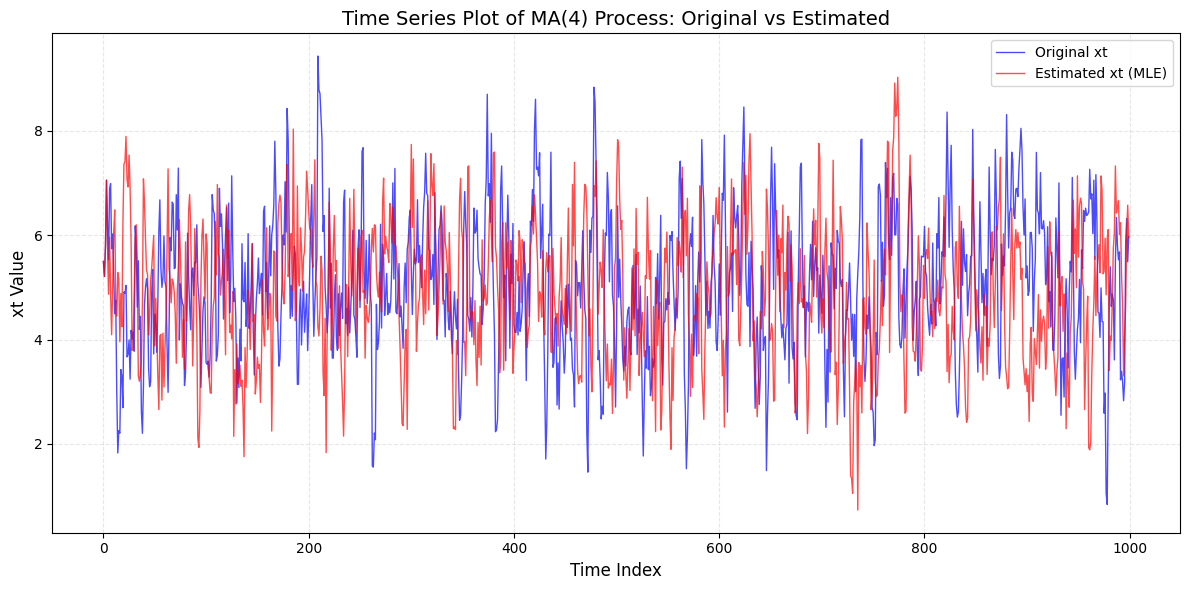

MLE Results:
MAqMLE Results Summary:
-----------------------
Parameter  Estimate     Std. Error  
alpha          4.994385          nan
beta1          0.686425     0.000971
beta2          0.478141     0.002343
beta3          0.285257          nan
beta4          0.188485     0.000481
sigma          1.003229     0.004544

Log-likelihood: -14221.488023

True values:
ALPHA: 5
BETA1: 0.7
BETA2: 0.5
BETA3: 0.3
BETA4: 0.2
STD: 1

Estimated values:
Estimated ALPHA: 4.994385021249747
Estimated BETA1: 0.6864251262407304
Estimated BETA2: 0.47814125737853497
Estimated BETA3: 0.2852569140498441
Estimated BETA4: 0.18848495301640736
Estimated STD: 1.0032291525096249


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_fprime

def generate_maq_data(q, alpha, betas, std, N):
    """Generate data for MA(q) process"""
    if len(betas) != q:
        raise ValueError(f"Number of betas ({len(betas)}) must match q ({q})")

    np.random.seed(42)  # for reproducibility
    et = np.random.normal(loc=0, scale=std, size=N)
    xt = [alpha + et[0]]
    for t in range(1, N):
        xt_t = alpha + et[t]
        for j in range(min(t, q)):
            xt_t += betas[j] * et[t-j-1]
        xt.append(xt_t)
    return np.array(xt), et

class MAqMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, q, **kwds):
        self.q = q
        super(MAqMLE, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        return -self.loglikeobs(params).sum()

    def loglikeobs(self, params):
        alpha, betas, sigma = params[0], params[1:-1], params[-1]
        ets = self.calc_conditional_et(alpha, betas, sigma)
        return stats.norm.logpdf(ets, scale=sigma)

    def initialize(self):
        super().initialize()
        extra_params_names = [f'beta{i+1}' for i in range(self.q)] + ['sigma']
        self._set_extra_params_names(extra_params_names)
        self.start_params = np.concatenate(([np.mean(self.endog)],  # alpha
                                            [0.1] * self.q,  # betas
                                            [np.std(self.endog)]))  # sigma

    def calc_conditional_et(self, alpha, betas, sigma):
        xt = self.endog
        et = np.zeros_like(xt)
        for t in range(len(xt)):
            et[t] = xt[t] - alpha
            for j in range(min(t, self.q)):
                et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
        return et

    def fit(self, start_params=None, maxiter=10000, method='L-BFGS-B', **kwds):
        if start_params is None:
            start_params = self.start_params

        bounds = [(None, None)]  # alpha
        bounds.extend([(-0.99, 0.99) for _ in range(self.q)])  # betas
        bounds.append((1e-6, None))  # sigma

        results = minimize(self.nloglikeobs, start_params,
                           method=method, bounds=bounds,
                           options={'maxiter': maxiter})

        return self.process_results(results)

    def process_results(self, results):
        class ModelResults:
            pass

        res = ModelResults()
        res.params = results.x
        res.success = results.success
        res.nloglike = results.fun

        # Calculate standard errors
        hessian = approx_fprime(results.x, lambda x: approx_fprime(x, self.nloglikeobs))
        res.cov_params = np.linalg.inv(hessian)
        res.bse = np.sqrt(np.diag(res.cov_params))

        def summary(self):
            param_names = ['alpha'] + [f'beta{i}' for i in range(1, self.q+1)] + ['sigma']
            summary_str = "MAqMLE Results Summary:\n"
            summary_str += "-----------------------\n"
            summary_str += f"{'Parameter':<10} {'Estimate':<12} {'Std. Error':<12}\n"
            for name, param, se in zip(param_names, self.params, self.bse):
                summary_str += f"{name:<10} {param:12.6f} {se:12.6f}\n"
            summary_str += f"\nLog-likelihood: {-self.nloglike:.6f}"
            return summary_str

        res.summary = summary.__get__(res)
        res.q = self.q

        return res

def run_maq_simulation(q, ALPHA, BETAS, STD, N):
    # Generate data
    xt, et = generate_maq_data(q, ALPHA, BETAS, STD, N)
    df = pd.DataFrame({"xt": xt})

    # Fit the model
    df = sm.add_constant(df)  # add intercept for estimation (alpha)
    model = MAqMLE(df["xt"], df["const"], q=q)
    results = model.fit()

    # Generate estimated series
    estimated_params = results.params
    estimated_alpha = estimated_params[0]
    estimated_betas = estimated_params[1:-1]
    estimated_std = estimated_params[-1]

    estimated_et = np.random.normal(loc=0, scale=estimated_std, size=N)
    estimated_xt = list(df["xt"].iloc[:q])  # Start with the first q observed values

    for t in range(q, N):
        xt_t = estimated_alpha + estimated_et[t]
        for j in range(q):
            xt_t += estimated_betas[j] * estimated_et[t-j-1]
        estimated_xt.append(xt_t)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[:1000], df['xt'][:1000], color='blue', linewidth=1, alpha=0.7, label='Original xt')
    plt.plot(df.index[:1000], estimated_xt[:1000], color='red', linewidth=1, alpha=0.7, label='Estimated xt (MLE)')

    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('xt Value', fontsize=12)
    plt.title(f'Time Series Plot of MA({q}) Process: Original vs Estimated', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()

    # Print results
    print("MLE Results:")
    print(results.summary())
    print("\nTrue values:")
    print(f"ALPHA: {ALPHA}")
    for i, beta in enumerate(BETAS, 1):
        print(f"BETA{i}: {beta}")
    print(f"STD: {STD}")
    print("\nEstimated values:")
    print(f"Estimated ALPHA: {estimated_alpha}")
    for i, beta in enumerate(estimated_betas, 1):
        print(f"Estimated BETA{i}: {beta}")
    print(f"Estimated STD: {estimated_std}")

# Example usage
q = 4  # Order of MA process
N = 10000  # Number of data points
ALPHA = 5
BETAS = [0.7, 0.5, 0.3, 0.2]  # Beta coefficients for MA(q)
STD = 1

run_maq_simulation(q, ALPHA, BETAS, STD, N)

# You can easily change the parameters and run the simulation again, for example:
# q = 2
# ALPHA = 3
# BETAS = [0.6, 0.4]
# STD = 0.5
# N = 20000
# run_maq_simulation(q, ALPHA, BETAS, STD, N)

<ipython-input-7-be82d6a0de71>:52: RuntimeWarning: overflow encountered in scalar subtract
  et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
<ipython-input-7-be82d6a0de71>:52: RuntimeWarning: invalid value encountered in scalar subtract
  et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: overflow encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:305: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
<ipython-input-7-be82d6a0de71>:81: RuntimeWarning: invalid value encountered in sqrt
  res.bse = np.sqrt(np.diag(res.cov_params))


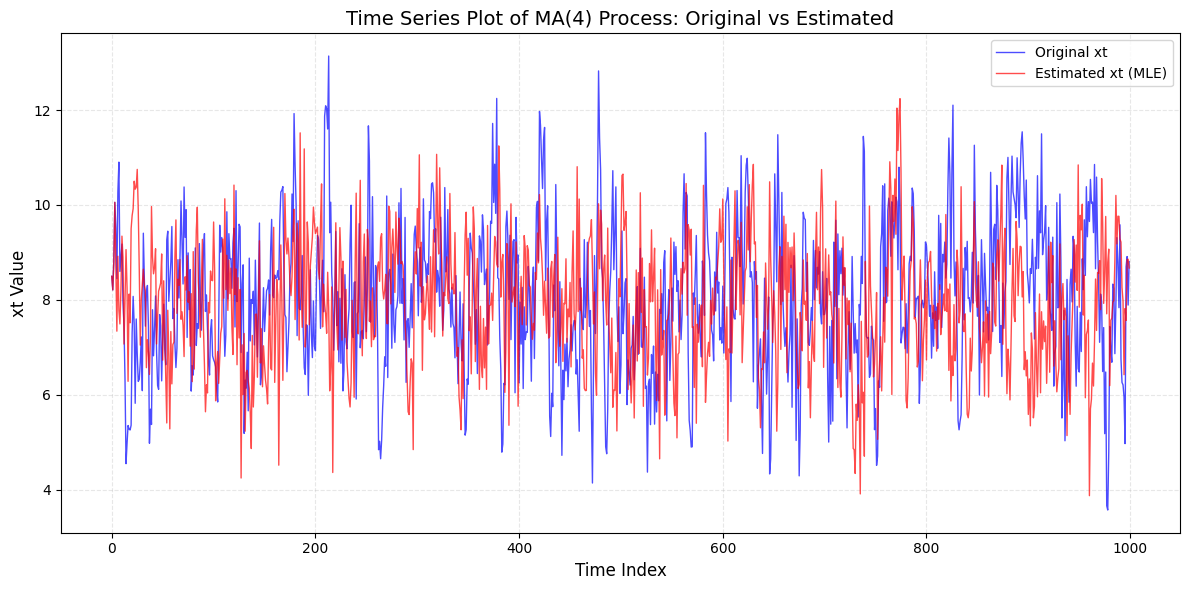

MLE Results:
MAqMLE Results Summary:
-----------------------
Parameter  Estimate     Std. Error  
alpha          8.018975     0.026562
beta1          0.375467     0.013656
beta2          0.311116          nan
beta3          0.309709          nan
beta4          0.489591          nan
sigma          1.091537          nan

Log-likelihood: nan

True values:
ALPHA: 8
BETA1: 0.7
BETA2: 0.5
BETA3: 0.3
BETA4: 0.8
STD: 1

Estimated values:
Estimated ALPHA: 8.018975454823423
Estimated BETA1: 0.3754670935096305
Estimated BETA2: 0.31111563379617346
Estimated BETA3: 0.309708805102745
Estimated BETA4: 0.4895914958833556
Estimated STD: 1.0915368470940896


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_fprime

def generate_maq_data(q, alpha, betas, std, N):
    """Generate data for MA(q) process"""
    if len(betas) != q:
        raise ValueError(f"Number of betas ({len(betas)}) must match q ({q})")

    np.random.seed(42)  # for reproducibility
    et = np.random.normal(loc=0, scale=std, size=N)
    xt = [alpha + et[0]]
    for t in range(1, N):
        xt_t = alpha + et[t]
        for j in range(min(t, q)):
            xt_t += betas[j] * et[t-j-1]
        xt.append(xt_t)
    return np.array(xt), et

class MAqMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, q, **kwds):
        self.q = q
        super(MAqMLE, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        return -self.loglikeobs(params).sum()

    def loglikeobs(self, params):
        alpha, betas, sigma = params[0], params[1:-1], params[-1]
        ets = self.calc_conditional_et(alpha, betas, sigma)
        return stats.norm.logpdf(ets, scale=sigma)

    def initialize(self):
        super().initialize()
        extra_params_names = [f'beta{i+1}' for i in range(self.q)] + ['sigma']
        self._set_extra_params_names(extra_params_names)
        self.start_params = np.concatenate(([np.mean(self.endog)],  # alpha
                                            [0.1] * self.q,  # betas
                                            [np.std(self.endog)]))  # sigma

    def calc_conditional_et(self, alpha, betas, sigma):
        xt = self.endog
        et = np.zeros_like(xt)
        for t in range(len(xt)):
            et[t] = xt[t] - alpha
            for j in range(min(t, self.q)):
                et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
        return et

    def fit(self, start_params=None, maxiter=10000, method='L-BFGS-B', **kwds):
        if start_params is None:
            start_params = self.start_params

        bounds = [(None, None)]  # alpha
        bounds.extend([(-0.99, 0.99) for _ in range(self.q)])  # betas
        bounds.append((1e-6, None))  # sigma

        results = minimize(self.nloglikeobs, start_params,
                           method=method, bounds=bounds,
                           options={'maxiter': maxiter})

        return self.process_results(results)

    def process_results(self, results):
        class ModelResults:
            pass

        res = ModelResults()
        res.params = results.x
        res.success = results.success
        res.nloglike = results.fun

        # Calculate standard errors
        hessian = approx_fprime(results.x, lambda x: approx_fprime(x, self.nloglikeobs))
        res.cov_params = np.linalg.inv(hessian)
        res.bse = np.sqrt(np.diag(res.cov_params))

        def summary(self):
            param_names = ['alpha'] + [f'beta{i}' for i in range(1, self.q+1)] + ['sigma']
            summary_str = "MAqMLE Results Summary:\n"
            summary_str += "-----------------------\n"
            summary_str += f"{'Parameter':<10} {'Estimate':<12} {'Std. Error':<12}\n"
            for name, param, se in zip(param_names, self.params, self.bse):
                summary_str += f"{name:<10} {param:12.6f} {se:12.6f}\n"
            summary_str += f"\nLog-likelihood: {-self.nloglike:.6f}"
            return summary_str

        res.summary = summary.__get__(res)
        res.q = self.q

        return res

def run_maq_simulation(q, ALPHA, BETAS, STD, N):
    # Generate data
    xt, et = generate_maq_data(q, ALPHA, BETAS, STD, N)
    df = pd.DataFrame({"xt": xt})

    # Fit the model
    df = sm.add_constant(df)  # add intercept for estimation (alpha)
    model = MAqMLE(df["xt"], df["const"], q=q)
    results = model.fit()

    # Generate estimated series
    estimated_params = results.params
    estimated_alpha = estimated_params[0]
    estimated_betas = estimated_params[1:-1]
    estimated_std = estimated_params[-1]

    estimated_et = np.random.normal(loc=0, scale=estimated_std, size=N)
    estimated_xt = list(df["xt"].iloc[:q])  # Start with the first q observed values

    for t in range(q, N):
        xt_t = estimated_alpha + estimated_et[t]
        for j in range(q):
            xt_t += estimated_betas[j] * estimated_et[t-j-1]
        estimated_xt.append(xt_t)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[:1000], df['xt'][:1000], color='blue', linewidth=1, alpha=0.7, label='Original xt')
    plt.plot(df.index[:1000], estimated_xt[:1000], color='red', linewidth=1, alpha=0.7, label='Estimated xt (MLE)')

    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('xt Value', fontsize=12)
    plt.title(f'Time Series Plot of MA({q}) Process: Original vs Estimated', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()

    # Print results
    print("MLE Results:")
    print(results.summary())
    print("\nTrue values:")
    print(f"ALPHA: {ALPHA}")
    for i, beta in enumerate(BETAS, 1):
        print(f"BETA{i}: {beta}")
    print(f"STD: {STD}")
    print("\nEstimated values:")
    print(f"Estimated ALPHA: {estimated_alpha}")
    for i, beta in enumerate(estimated_betas, 1):
        print(f"Estimated BETA{i}: {beta}")
    print(f"Estimated STD: {estimated_std}")

# Example usage
q = 4  # Order of MA process
N = 10000  # Number of data points
ALPHA = 8
BETAS = [0.7, 0.5, 0.3, 0.8]  # Beta coefficients for MA(q)
STD = 1

run_maq_simulation(q, ALPHA, BETAS, STD, N)

# You can easily change the parameters and run the simulation again, for example:
# q = 2
# ALPHA = 3
# BETAS = [0.6, 0.4]
# STD = 0.5
# N = 20000
# run_maq_simulation(q, ALPHA, BETAS, STD, N)

<ipython-input-9-6ca4e766a55e>:81: RuntimeWarning: invalid value encountered in sqrt
  res.bse = np.sqrt(np.diag(res.cov_params))


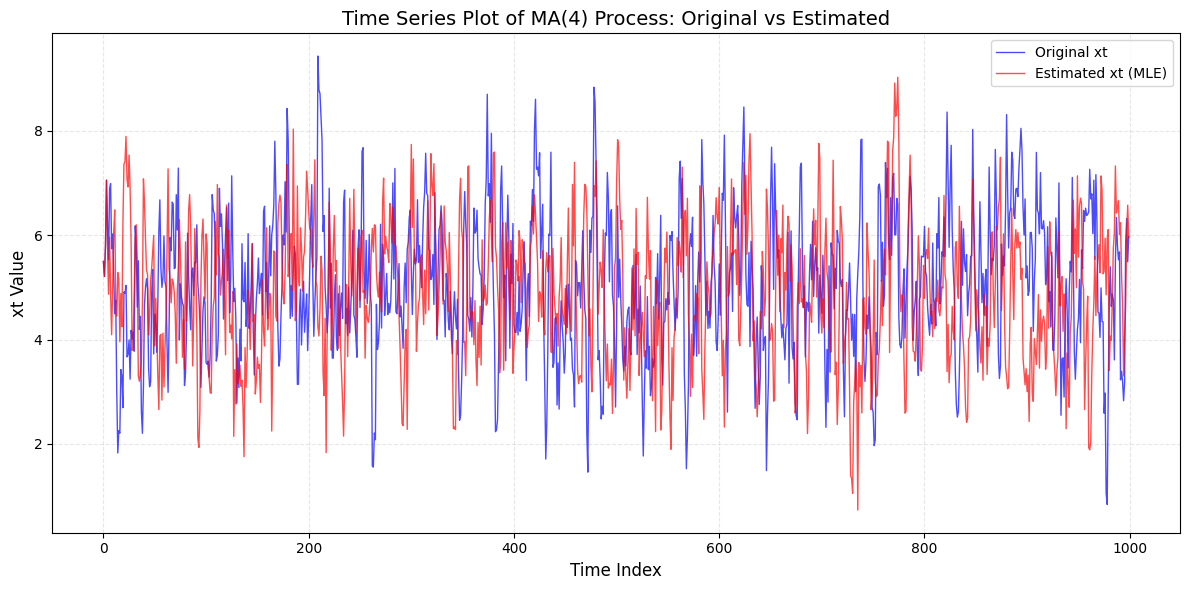

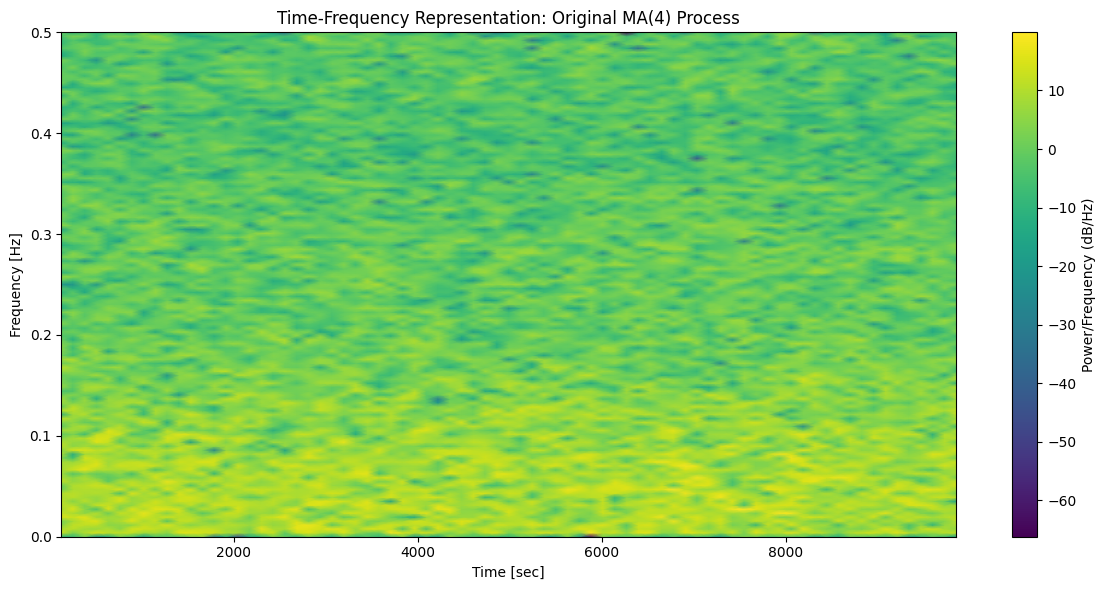

AttributeError: 'list' object has no attribute 'shape'

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_fprime

def generate_maq_data(q, alpha, betas, std, N):
    """Generate data for MA(q) process"""
    if len(betas) != q:
        raise ValueError(f"Number of betas ({len(betas)}) must match q ({q})")

    np.random.seed(42)  # for reproducibility
    et = np.random.normal(loc=0, scale=std, size=N)
    xt = [alpha + et[0]]
    for t in range(1, N):
        xt_t = alpha + et[t]
        for j in range(min(t, q)):
            xt_t += betas[j] * et[t-j-1]
        xt.append(xt_t)
    return np.array(xt), et

class MAqMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, q, **kwds):
        self.q = q
        super(MAqMLE, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        return -self.loglikeobs(params).sum()

    def loglikeobs(self, params):
        alpha, betas, sigma = params[0], params[1:-1], params[-1]
        ets = self.calc_conditional_et(alpha, betas, sigma)
        return stats.norm.logpdf(ets, scale=sigma)

    def initialize(self):
        super().initialize()
        extra_params_names = [f'beta{i+1}' for i in range(self.q)] + ['sigma']
        self._set_extra_params_names(extra_params_names)
        self.start_params = np.concatenate(([np.mean(self.endog)],  # alpha
                                            [0.1] * self.q,  # betas
                                            [np.std(self.endog)]))  # sigma

    def calc_conditional_et(self, alpha, betas, sigma):
        xt = self.endog
        et = np.zeros_like(xt)
        for t in range(len(xt)):
            et[t] = xt[t] - alpha
            for j in range(min(t, self.q)):
                et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
        return et

    def fit(self, start_params=None, maxiter=10000, method='L-BFGS-B', **kwds):
        if start_params is None:
            start_params = self.start_params

        bounds = [(None, None)]  # alpha
        bounds.extend([(-0.99, 0.99) for _ in range(self.q)])  # betas
        bounds.append((1e-6, None))  # sigma

        results = minimize(self.nloglikeobs, start_params,
                           method=method, bounds=bounds,
                           options={'maxiter': maxiter})

        return self.process_results(results)

    def process_results(self, results):
        class ModelResults:
            pass

        res = ModelResults()
        res.params = results.x
        res.success = results.success
        res.nloglike = results.fun

        # Calculate standard errors
        hessian = approx_fprime(results.x, lambda x: approx_fprime(x, self.nloglikeobs))
        res.cov_params = np.linalg.inv(hessian)
        res.bse = np.sqrt(np.diag(res.cov_params))

        def summary(self):
            param_names = ['alpha'] + [f'beta{i}' for i in range(1, self.q+1)] + ['sigma']
            summary_str = "MAqMLE Results Summary:\n"
            summary_str += "-----------------------\n"
            summary_str += f"{'Parameter':<10} {'Estimate':<12} {'Std. Error':<12}\n"
            for name, param, se in zip(param_names, self.params, self.bse):
                summary_str += f"{name:<10} {param:12.6f} {se:12.6f}\n"
            summary_str += f"\nLog-likelihood: {-self.nloglike:.6f}"
            return summary_str

        res.summary = summary.__get__(res)
        res.q = self.q

        return res
def plot_time_frequency(xt, fs=1.0, nperseg=256, noverlap=128, title=''):
    f, t, Sxx = signal.spectrogram(xt, fs=fs, nperseg=nperseg, noverlap=noverlap)

    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Time-Frequency Representation: {title}')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.tight_layout()
    plt.show()

def plot_power_spectrum(xt, fs=1.0, nperseg=256, title=''):
    f, Pxx = signal.welch(xt, fs=fs, nperseg=nperseg)

    plt.figure(figsize=(12, 6))
    plt.semilogy(f, Pxx)
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlabel('Frequency [Hz]')
    plt.title(f'Power Spectral Density: {title}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_maq_simulation(q, ALPHA, BETAS, STD, N):
    # Generate data
    xt, et = generate_maq_data(q, ALPHA, BETAS, STD, N)
    df = pd.DataFrame({"xt": xt})

    # Fit the model
    df = sm.add_constant(df)  # add intercept for estimation (alpha)
    model = MAqMLE(df["xt"], df["const"], q=q)
    results = model.fit()

    # Generate estimated series
    estimated_params = results.params
    estimated_alpha = estimated_params[0]
    estimated_betas = estimated_params[1:-1]
    estimated_std = estimated_params[-1]

    estimated_et = np.random.normal(loc=0, scale=estimated_std, size=N)
    estimated_xt = list(df["xt"].iloc[:q])  # Start with the first q observed values

    for t in range(q, N):
        xt_t = estimated_alpha + estimated_et[t]
        for j in range(q):
            xt_t += estimated_betas[j] * estimated_et[t-j-1]
        estimated_xt.append(xt_t)

    # Create the time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[:1000], df['xt'][:1000], color='blue', linewidth=1, alpha=0.7, label='Original xt')
    plt.plot(df.index[:1000], estimated_xt[:1000], color='red', linewidth=1, alpha=0.7, label='Estimated xt (MLE)')

    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('xt Value', fontsize=12)
    plt.title(f'Time Series Plot of MA({q}) Process: Original vs Estimated', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()

    # Plot Time-Frequency representations
    plot_time_frequency(df['xt'], title=f'Original MA({q}) Process')
    plot_time_frequency(estimated_xt, title=f'Estimated MA({q}) Process')

    # Plot Power Spectra
    plot_power_spectrum(df['xt'], title=f'Original MA({q}) Process')
    plot_power_spectrum(estimated_xt, title=f'Estimated MA({q}) Process')

    # Print results
    print("MLE Results:")
    print(results.summary())
    print("\nTrue values:")
    print(f"ALPHA: {ALPHA}")
    for i, beta in enumerate(BETAS, 1):
        print(f"BETA{i}: {beta}")
    print(f"STD: {STD}")
    print("\nEstimated values:")
    print(f"Estimated ALPHA: {estimated_alpha}")
    for i, beta in enumerate(estimated_betas, 1):
        print(f"Estimated BETA{i}: {beta}")
    print(f"Estimated STD: {estimated_std}")

# Example usage
q = 4  # Order of MA process
N = 10000  # Number of data points
ALPHA = 5
BETAS = [0.7, 0.5, 0.3, 0.2]  # Beta coefficients for MA(q)
STD = 1

run_maq_simulation(q, ALPHA, BETAS, STD, N)

# You can easily change the parameters and run the simulation again, for example:
# q = 2
# ALPHA = 3
# BETAS = [0.6, 0.4]
# STD = 0.5
# N = 20000
# run_maq_simulation(q, ALPHA, BETAS, STD, N)

<ipython-input-10-10dce9622825>:81: RuntimeWarning: invalid value encountered in sqrt
  res.bse = np.sqrt(np.diag(res.cov_params))


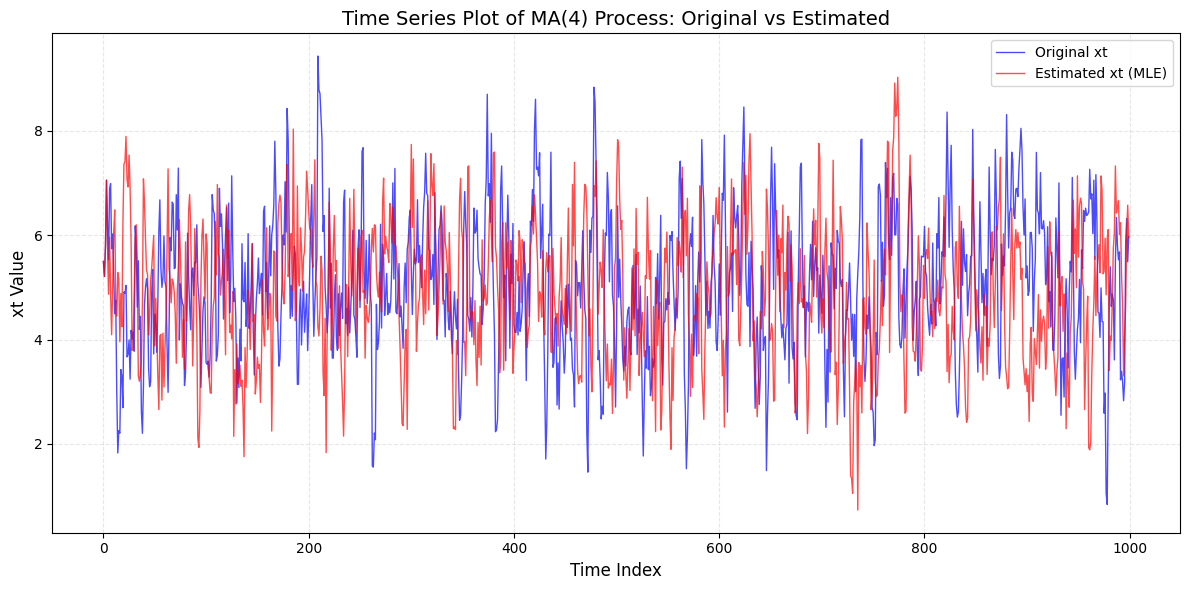

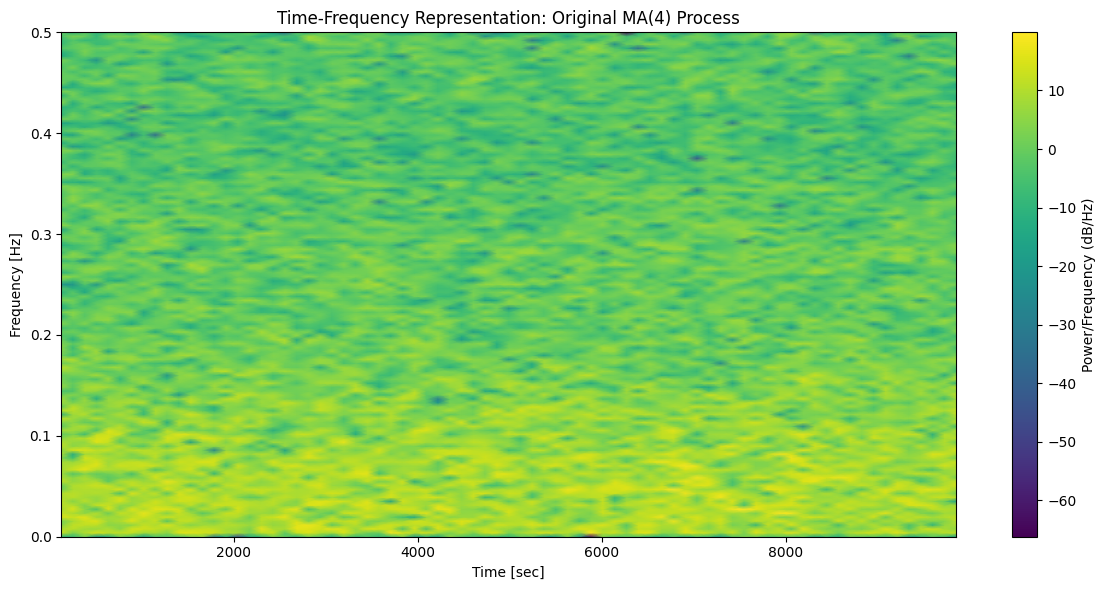

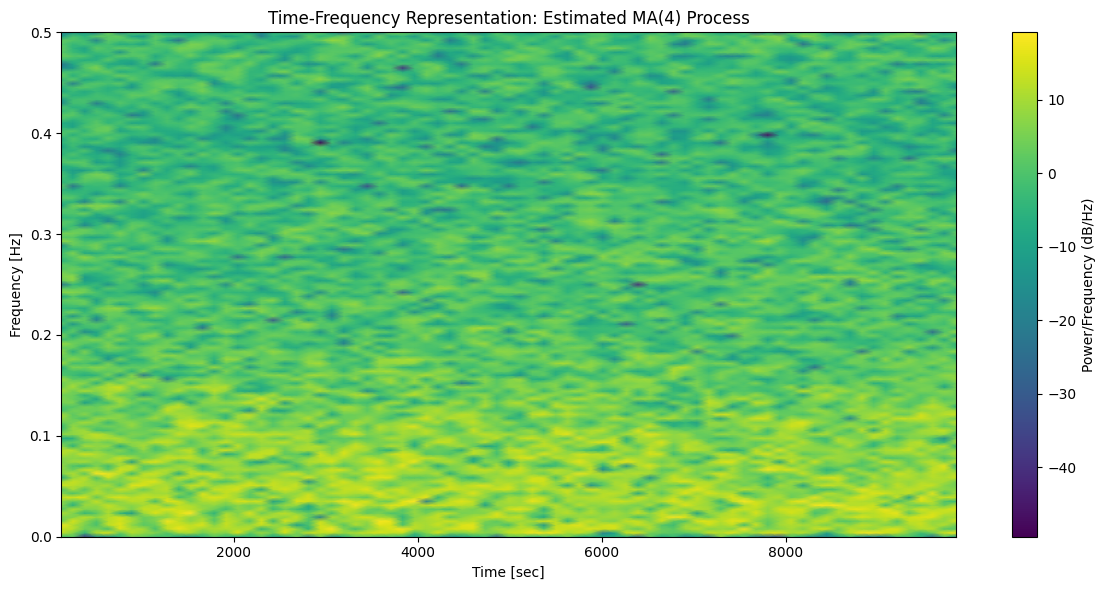

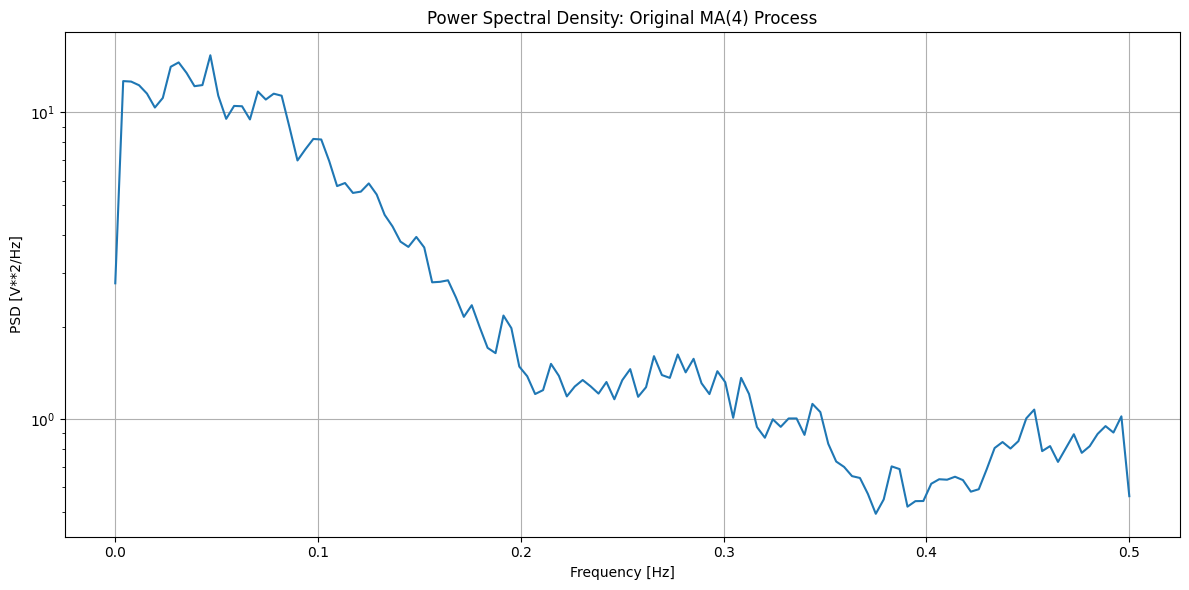

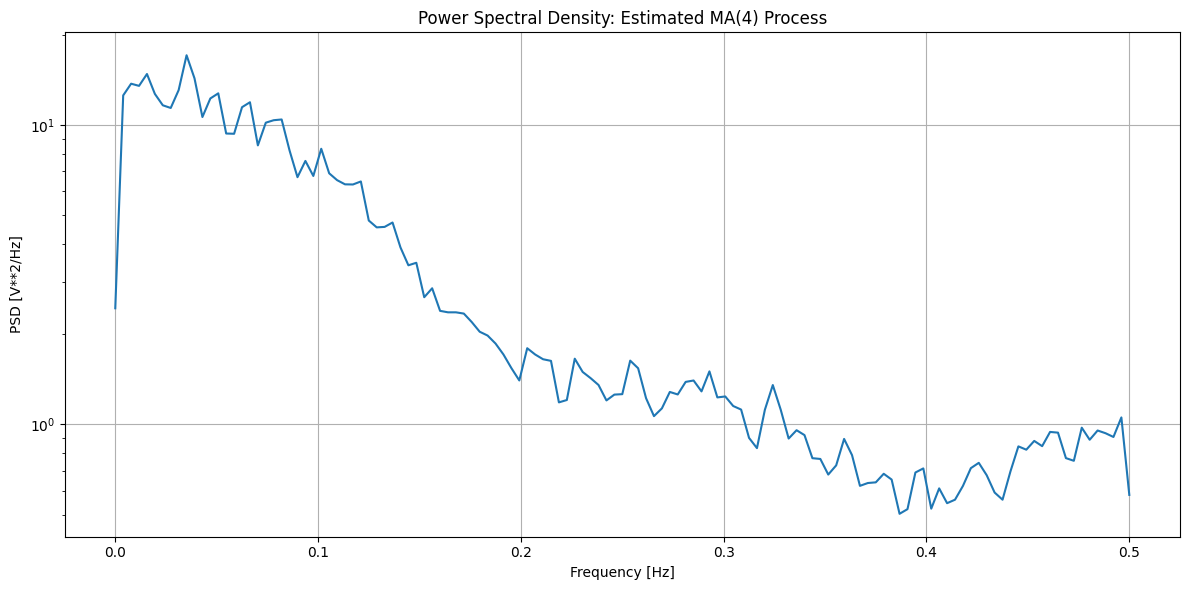

MLE Results:
MAqMLE Results Summary:
-----------------------
Parameter  Estimate     Std. Error  
alpha          4.994385          nan
beta1          0.686425     0.000971
beta2          0.478141     0.002343
beta3          0.285257          nan
beta4          0.188485     0.000481
sigma          1.003229     0.004544

Log-likelihood: -14221.488023

True values:
ALPHA: 5
BETA1: 0.7
BETA2: 0.5
BETA3: 0.3
BETA4: 0.2
STD: 1

Estimated values:
Estimated ALPHA: 4.994385021249747
Estimated BETA1: 0.6864251262407304
Estimated BETA2: 0.47814125737853497
Estimated BETA3: 0.2852569140498441
Estimated BETA4: 0.18848495301640736
Estimated STD: 1.0032291525096249


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_fprime

def generate_maq_data(q, alpha, betas, std, N):
    """Generate data for MA(q) process"""
    if len(betas) != q:
        raise ValueError(f"Number of betas ({len(betas)}) must match q ({q})")

    np.random.seed(42)  # for reproducibility
    et = np.random.normal(loc=0, scale=std, size=N)
    xt = [alpha + et[0]]
    for t in range(1, N):
        xt_t = alpha + et[t]
        for j in range(min(t, q)):
            xt_t += betas[j] * et[t-j-1]
        xt.append(xt_t)
    return np.array(xt), et

class MAqMLE(GenericLikelihoodModel):
    def __init__(self, endog, exog, q, **kwds):
        self.q = q
        super(MAqMLE, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        return -self.loglikeobs(params).sum()

    def loglikeobs(self, params):
        alpha, betas, sigma = params[0], params[1:-1], params[-1]
        ets = self.calc_conditional_et(alpha, betas, sigma)
        return stats.norm.logpdf(ets, scale=sigma)

    def initialize(self):
        super().initialize()
        extra_params_names = [f'beta{i+1}' for i in range(self.q)] + ['sigma']
        self._set_extra_params_names(extra_params_names)
        self.start_params = np.concatenate(([np.mean(self.endog)],  # alpha
                                            [0.1] * self.q,  # betas
                                            [np.std(self.endog)]))  # sigma

    def calc_conditional_et(self, alpha, betas, sigma):
        xt = self.endog
        et = np.zeros_like(xt)
        for t in range(len(xt)):
            et[t] = xt[t] - alpha
            for j in range(min(t, self.q)):
                et[t] -= betas[j] * et[t-j-1] if t-j-1 >= 0 else 0
        return et

    def fit(self, start_params=None, maxiter=10000, method='L-BFGS-B', **kwds):
        if start_params is None:
            start_params = self.start_params

        bounds = [(None, None)]  # alpha
        bounds.extend([(-0.99, 0.99) for _ in range(self.q)])  # betas
        bounds.append((1e-6, None))  # sigma

        results = minimize(self.nloglikeobs, start_params,
                           method=method, bounds=bounds,
                           options={'maxiter': maxiter})

        return self.process_results(results)

    def process_results(self, results):
        class ModelResults:
            pass

        res = ModelResults()
        res.params = results.x
        res.success = results.success
        res.nloglike = results.fun

        # Calculate standard errors
        hessian = approx_fprime(results.x, lambda x: approx_fprime(x, self.nloglikeobs))
        res.cov_params = np.linalg.inv(hessian)
        res.bse = np.sqrt(np.diag(res.cov_params))

        def summary(self):
            param_names = ['alpha'] + [f'beta{i}' for i in range(1, self.q+1)] + ['sigma']
            summary_str = "MAqMLE Results Summary:\n"
            summary_str += "-----------------------\n"
            summary_str += f"{'Parameter':<10} {'Estimate':<12} {'Std. Error':<12}\n"
            for name, param, se in zip(param_names, self.params, self.bse):
                summary_str += f"{name:<10} {param:12.6f} {se:12.6f}\n"
            summary_str += f"\nLog-likelihood: {-self.nloglike:.6f}"
            return summary_str

        res.summary = summary.__get__(res)
        res.q = self.q

        return res

def plot_time_frequency(xt, fs=1.0, nperseg=256, noverlap=128, title=''):
    f, t, Sxx = signal.spectrogram(xt, fs=fs, nperseg=nperseg, noverlap=noverlap)

    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Time-Frequency Representation: {title}')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.tight_layout()
    plt.show()

def plot_power_spectrum(xt, fs=1.0, nperseg=256, title=''):
    f, Pxx = signal.welch(xt, fs=fs, nperseg=nperseg)

    plt.figure(figsize=(12, 6))
    plt.semilogy(f, Pxx)
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlabel('Frequency [Hz]')
    plt.title(f'Power Spectral Density: {title}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_maq_simulation(q, ALPHA, BETAS, STD, N):
    # Generate data
    xt, et = generate_maq_data(q, ALPHA, BETAS, STD, N)
    df = pd.DataFrame({"xt": xt})

    # Fit the model
    df = sm.add_constant(df)  # add intercept for estimation (alpha)
    model = MAqMLE(df["xt"], df["const"], q=q)
    results = model.fit()

    # Generate estimated series
    estimated_params = results.params
    estimated_alpha = estimated_params[0]
    estimated_betas = estimated_params[1:-1]
    estimated_std = estimated_params[-1]

    estimated_et = np.random.normal(loc=0, scale=estimated_std, size=N)
    estimated_xt = np.zeros(N)
    estimated_xt[:q] = df["xt"].iloc[:q]  # Start with the first q observed values

    for t in range(q, N):
        estimated_xt[t] = estimated_alpha + estimated_et[t]
        for j in range(q):
            estimated_xt[t] += estimated_betas[j] * estimated_et[t-j-1]

    # Create the time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[:1000], df['xt'][:1000], color='blue', linewidth=1, alpha=0.7, label='Original xt')
    plt.plot(df.index[:1000], estimated_xt[:1000], color='red', linewidth=1, alpha=0.7, label='Estimated xt (MLE)')

    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('xt Value', fontsize=12)
    plt.title(f'Time Series Plot of MA({q}) Process: Original vs Estimated', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()

    # Plot Time-Frequency representations
    plot_time_frequency(df['xt'].values, title=f'Original MA({q}) Process')
    plot_time_frequency(estimated_xt, title=f'Estimated MA({q}) Process')

    # Plot Power Spectra
    plot_power_spectrum(df['xt'].values, title=f'Original MA({q}) Process')
    plot_power_spectrum(estimated_xt, title=f'Estimated MA({q}) Process')

    # Print results
    print("MLE Results:")
    print(results.summary())
    print("\nTrue values:")
    print(f"ALPHA: {ALPHA}")
    for i, beta in enumerate(BETAS, 1):
        print(f"BETA{i}: {beta}")
    print(f"STD: {STD}")
    print("\nEstimated values:")
    print(f"Estimated ALPHA: {estimated_alpha}")
    for i, beta in enumerate(estimated_betas, 1):
        print(f"Estimated BETA{i}: {beta}")
    print(f"Estimated STD: {estimated_std}")

# Example usage
q = 4  # Order of MA process
N = 10000  # Number of data points
ALPHA = 5
BETAS = [0.7, 0.5, 0.3, 0.2]  # Beta coefficients for MA(q)
STD = 1

run_maq_simulation(q, ALPHA, BETAS, STD, N)

# You can easily change the parameters and run the simulation again, for example:
# q = 2
# ALPHA = 3
# BETAS = [0.6, 0.4]
# STD = 0.5
# N = 20000
# run_maq_simulation(q, ALPHA, BETAS, STD, N)